In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from joblib import dump, load
from sklearn import set_config
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    make_scorer,
    auc,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, plot_tree

from ml_model import PipelineManager, PredictionPipeline
from utils.GPU_models import KerasClassifierModel, gpu_model_hub
from utils.preprocessing_utils import (
    clean_and_preprocess_datasets,
    clean_labs,
    clean_notas,
    clean_sociodemograficos,
    disease_tests_list,
    merge_classes,
    merge_labs_notas,
    word_count_feat_engineering,
)


2022-07-05 12:33:21.768702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 12:33:21.768747: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/juanma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/juanma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
set_config(display="diagram")
sns.set_style("darkgrid")

png_renderer = pio.renderers["png"]
png_renderer.width = 1024
png_renderer.height = 768

pio.renderers.default = "png"

# Feature and data config
balance_classes = "oversample"  # False, 'oversample', or 'undersample'
retrain_with_class_weight = False
add_gpu_prediction = False
consolidate_classes = False
as_dual_class = False
target_feature = "Código"
text_feature = "Plan"

# Should the best performing model be retrained with the fulldataset?
refit_model = True

# Hyperparameter tuning configuration
fit_pipeline = False
cv = 3
n_iter = 8
n_jobs = -3
random_state=612

# Paths
cleaning_dict_path = "utils/lab_test_name_aggregation.json"
save_path = Path("data") / "output" / "best_model.pickle"
figure_save_path = Path("data") / "output" / "figures"
prediction_pipeline_savepath = Path("model") / "prediction_pipeline.pickle"
fmap_save_path = save_path.parent / "feature_map.txt"

save_path.parent.mkdir(parents=True, exist_ok=True)
figure_save_path.mkdir(parents=True, exist_ok=True)
prediction_pipeline_savepath.parent.mkdir(parents=True, exist_ok=True)

## Data setup

In [3]:
with open(cleaning_dict_path, "r") as in_file:
    dict_tests = json.load(in_file)

df_notas = pd.read_csv("data/notas.csv", sep=";")
df_laboratorios = pd.read_csv("data/laboratorios.csv", sep=";")
df_sociodemografico = pd.read_csv("data/sociodemografico.csv", sep=";")


In [4]:
df_notas.head()


,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [5]:
df_laboratorios.head()


,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [6]:
df_sociodemografico.head()


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


## Data Cleaning

In [7]:
df_sociodemografico = clean_sociodemograficos(df_sociodemografico)
df_laboratorios = clean_labs(df_laboratorios, name_aggregation_dict=dict_tests)
df_notas = clean_notas(df_notas, apply_lemmatization=False)


### Merge the sociodemographic data with the medical notes dataset

In [8]:
df_merge = df_sociodemografico.merge(df_notas, how="inner", on="IDRecord")
df_merge


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA EN PROGRAMA DE CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...
...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,"se explica acerca del programa, Se recomienda ..."
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Elaboracion duelo frente al diagnostico. Ref...
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,FUROATO MOMETASONA 1 SPRY NASAL POR CADA FOSA ...
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,CONTROL MEICO EN UN MES-INFECTOLOGIA VALORACI...


## Feature Engineering

In [9]:
# Consolidate the classes
if consolidate_classes:
    df_merge = merge_classes(df_merge)

# Perform word count feature engineering
df_merge = word_count_feat_engineering(df_merge)

# Preprocess the lab data and merge it with the sociodemographic data
df_merge = merge_labs_notas(df_laboratorios, df_merge)

with pd.option_context("display.max_columns", None):
    display(df_merge.head(5))


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan,acido,antibio,asintoma,cabeza,diabet,diet,gluco,hepat,insulin,keto,penici,preservativo,rpr,sable,serolo,sifili,test_reloj_orden,vih,top_lab_name,top_lab_avg_value,top_lab_max_value,top_lab_count,total_lab_count,first_lab_date,last_lab_date,date_diff_first_last,date_diff_mean,date_diff_max,liver_damage_count,liver_damage_max,hematic_info_count,hematic_info_max,bacterias_count,bacterias_max,hormones_count,hormones_max,other_diseases_count,other_diseases_max,kidney_damage_count,kidney_damage_max,heart_damage_count,heart_damage_max,minerals_count,minerals_max,white_cells_count,white_cells_max,vih_count,vih_max,diabetes_tests_count,diabetes_tests_max,syphilis_tests_count,syphilis_tests_max
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE QUIEN CONTINUA EN PROGRAMA DE NEFROPR...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,colesterol test,108.333333,150.0,3.0,8.0,1.609114e+09,1.609114e+09,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,1.0,189.0,0.0,0.0,2.0,500.0,3.0,150.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA EN PROGRAMA DE CRONICOS.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR EN PAD 2 - RECOMENDACIONES DE DIE...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Label encoding

In [10]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    # Remove all but the first two characters of the classes, i.e. A5 or E1
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

np.unique(y_labels, return_counts=True)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  977,    94,  2614,  1970, 60586, 47408,  6278, 17437,  2808]))

## Train-test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_labels, train_size=0.2, random_state=42, stratify=y_labels
)
np.unique(y_train, return_counts=True)  # Let's check the number of samples per label


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  195,    19,   523,   394, 12117,  9481,  1256,  3487,   562]))

## Class Balancing

In [12]:
if balance_classes == "oversample":
    # Using a naive oversampling approach
    sampler = RandomOverSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
elif balance_classes == "undersample":
    # Using a naive oversampling approach
    sampler = RandomUnderSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True)  # Let's check the number of samples per label


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([12117, 12117, 12117, 12117, 12117, 12117, 12117, 12117, 12117]))

## Further (optional) feature engineering

In [13]:
# embedding = "nnlm-es-dim128"
embedding = "nnlm-es-dim128-with-normalization"
# embedding = "universal"

if add_gpu_prediction:
    model_function = gpu_model_hub
    clf = KerasClassifierModel(
        build_fn=model_function,
        class_number=len(df_notas[target_feature].unique()),
        embedding=embedding,
        epochs=400,
        batch_size=400,
        verbose=10,
    )

    clf.fit(X_train[text_feature], y_train)
    clf.plot_learning_curves("data/output/gpu_model")


In [14]:
if add_gpu_prediction:
    y_pred = clf.predict(X_test[text_feature])
    display(
        pd.DataFrame(
            classification_report(y_test, y_pred, output_dict=True)
        ).transpose()
    )


In [15]:
if add_gpu_prediction:
    X_pred = clf.predict(df_merge[text_feature])
    df_merge["GPU_prediction"] = X_pred
    df_merge


## Hyperparameter Setup

In [16]:
# Select the numerical features that will be used in the model
numerical_features = list(
    set(
        [
            "Edad",
            "top_lab_avg_value",
            "top_lab_max_value",
            "top_lab_count",
            "total_lab_count",
            "date_diff_mean",
            "date_diff_max",
            "first_lab_date",
            "last_lab_date",
            "date_diff_first_last",
        ]
        + list(df_merge.drop(columns="IDRecord").select_dtypes(include="int64").columns)
        + [f"{test[1]}_count" for test in disease_tests_list()]
        + [f"{test[1]}_max" for test in disease_tests_list()]
    )
)

# Now select the categorical features
categorical_features = [
    "Genero",
    "GrupoEtnico",
    # "AreaResidencial",
    "EstadoCivil",
    # "TSangre",
    # "Tipo",
    "top_lab_name",
]


In [17]:
# Add the GPU prediction if we are using a GPU model for predicting the data
if "GPU_prediction" in df_merge:
    categorical_features.append("GPU_prediction")

pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
pipeline.set_text_feature(text_feature)
pipeline.set_basic_pipeline()

param_grid = {
    "n_estimators": np.linspace(10, 100, 10, dtype=int),
    "max_depth": list(np.linspace(2, 20, 5, dtype=int)),
    "eta": np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 10, 5, dtype=float),
    "reg_alpha": np.linspace(0, 10, 5, dtype=float),
    # "scale_pos_weight": np.linspace(0.1, 500, 100, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
    "C": np.linspace(0, 5, 20, dtype=float),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["auto", "scale"],
    "class_weight": ["balanced", None],
    "coef0": np.linspace(0, 5, 20, dtype=float),
    "degree": np.linspace(1, 5, 10, dtype=int),
}
estimator = SVC()
pipeline.add_estimator(estimator, param_grid)


pipeline.pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'EstadoCivil',
                                                   'top_lab_name']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScal...
                                                                   CountVectorizer(stop_words=['de',
                                                                                               'la',
                                                                                               'que',
                                                                                               'el',
                                                                                               'en',
                                                                                               'y',
                                                                                               'a',
                                                                                               'los',
                                                                                               'del',
                                                                                               'se',
                                                                                               'las',
                                                                                               'por',
                                                                                               'un',
                                                                                               'para',
                                                                                               'con',
                                                                                               'no',
                                                                                               'una',
                                                                                               'su',
                                                                                               'al',
                                                                                               'lo',
                                                                                               'como',
                                                                                               'mas',
                                                                                               'pero',
                                                                                               'sus',
                                                                                               'le',
                                                                                               'ya',
                                                                                               'o',
                                                                                             

## Hyperparameter tuning

In [18]:
scoring = {
    "Accuracy": "balanced_accuracy",
    "Weighted_F1": make_scorer(f1_score, average="weighted"),
    # 'roc_auc':make_scorer(roc_auc_score, average='weighted'),
}
if not fit_pipeline and not save_path.is_file():
    print(f"Could not find saved model in {save_path.resolve()}, retraining pipeline")
    fit_pipeline = True

if fit_pipeline:
    best_model = pipeline.find_best_model(
        X_train,
        y_train,
        cv=cv,
        n_iter=n_iter,
        n_jobs=n_jobs,
        scoring=scoring,
        random_state=random_state,
        refit="Weighted_F1",
        verbose=5,
        # error_score='raise',
    )
    with pd.option_context("display.max_columns", None):
        display(pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))
    # dump(pipeline, str(save_path.parent / f"training_pipeline{save_path.suffix}"))
else:
    best_model = load(save_path)
    # pipeline = load(str(save_path.parent / f"training_pipeline{save_path.suffix}"))


In [19]:
best_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'EstadoCivil',
                                                   'top_lab_name']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bacter...
                               eval_metric=None, gamma=0.75, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.391111106, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=11, max_leaves=0,
                               min_child_weight=5.375, missing=nan,
                               monotone_constraints='()', n_estimators=67,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, ...))])

In [20]:
if fit_pipeline:
    with pd.option_context("display.max_columns", None):
        display(pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))


In [21]:
# Retrain the model using a sample-weighting mechanism to try to compensate for the dataset imbalance
if retrain_with_class_weight:
    sample_weights = compute_sample_weight(
        class_weight="balanced",
        y=y_train,
    )

    best_model.fit(X_train, y_train, estimator__sample_weight=sample_weights)


## Scoring

In [22]:
if fit_pipeline:
    score = pipeline.score(X_test, y_test)
    display(score)


### Confusion Matrix

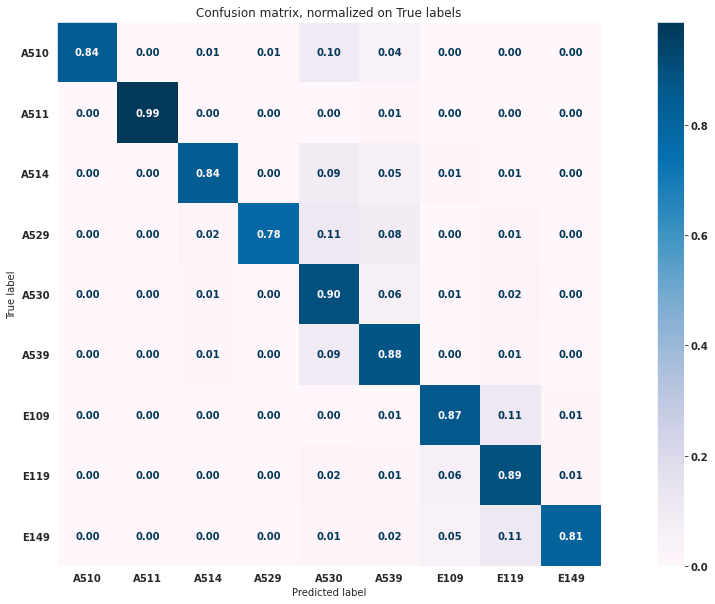

In [23]:
labels_decoded = label_encoder.inverse_transform(best_model["estimator"].classes_)

font = {"family": "normal", "weight": "bold", "size": 14}

plt.rc("font", **font)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20, 10))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        best_model.predict(X_test),
        display_labels=labels_decoded,
        normalize="true",
        ax=ax,
        cmap="PuBu",
        values_format=".2f",
    )
    _ = ax.set_title(f"Confusion matrix, normalized on True labels")
    plt.show()

    figure_save_path.mkdir(parents=True, exist_ok=True)
    fig.savefig(str(figure_save_path / "confusion_matrix"), dpi=fig.dpi, transparent=True)


### Classification Report

In [24]:
pd.DataFrame(
            classification_report(y_test, best_model.predict(X_test), output_dict=True, target_names = labels_decoded)
            ).transpose().round(2)


,precision,recall,f1-score,support
A510,0.84,0.84,0.84,782.00
A511,0.82,0.99,0.90,75.00
A514,0.62,0.84,0.71,2091.00
A529,0.76,0.78,0.77,1576.00
A530,0.91,0.90,0.90,48469.00
A539,0.90,0.88,0.89,37927.00
E109,0.76,0.87,0.81,5022.00
E119,0.86,0.89,0.88,13950.00
E149,0.82,0.81,0.82,2246.00
accuracy,0.88,0.88,0.88,0.88


### ROC Curve

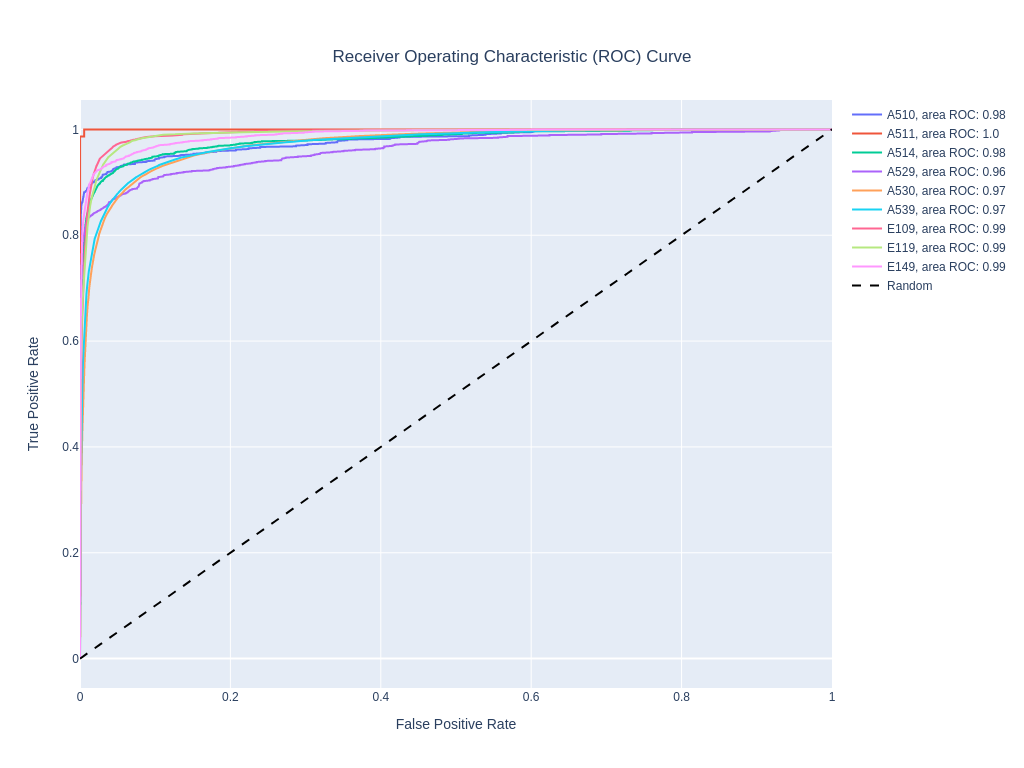

In [25]:
y_score = best_model.predict_proba(X_test)

n_classes = len(best_model["estimator"].classes_)

y_test_bin = label_binarize(y_test, classes=best_model["estimator"].classes_)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig = go.Figure()
for c in range(n_classes):
    label = f"{label_encoder.inverse_transform([np.array(c)])[0]}, area ROC: {round(roc_auc[c], 2)}"
    fig.add_traces(go.Scatter(x=fpr[c], y=tpr[c], mode="lines", name=label))
fig.add_traces(
    go.Scatter(x=fpr[c], y=fpr[c], name="Random", line=dict(color="black", dash="dash"))
)

fig.update_xaxes(title_text="False Positive Rate")
fig.update_yaxes(title_text="True Positive Rate")
fig.update_layout(title={
            'text': "Receiver Operating Characteristic (ROC) Curve",
            # 'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},)
fig.show()
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)',
            )
fig.write_image(str(figure_save_path / 'ROC Curve.png'), width=1024, height=768, scale=2)

# Model Characterization

## Model Features

In [26]:
# Building the fmap file needed to correctly give names to the features in the decision tree plot
fmap = pd.DataFrame(
    best_model.named_steps["feature_selector"].get_feature_names_out(
        best_model.named_steps["preprocessor"].get_feature_names_out()
    ),
    columns=["feature"],
)
# Feature type q is quantitative, feature type i is binary
fmap["feature_type"] = "i"
fmap.loc[fmap.feature.str.contains("numerical__"), "feature_type"] = "q"
fmap["feature"] = fmap.feature.str.replace(" ", "_")
fmap["feature"] = fmap.feature.str.replace("numerical__", "")
fmap["feature"] = fmap.feature.str.replace("categorical__", "")
fmap.to_csv(str(fmap_save_path), sep="\t", header=False)
fmap


,feature,feature_type
0,Genero_Hombre,i
1,Genero_Mujer,i
2,GrupoEtnico_Blanco,i
3,GrupoEtnico_Indígena,i
4,GrupoEtnico_Mestizo,i
...,...,...
187999,text__zucares_simples,i
188000,text__zuldemaida_municipio,i
188001,text__zuletas_carrera,i
188002,text__zumbidos_oidos,i


Now let's plot one of the XGBoost trees

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


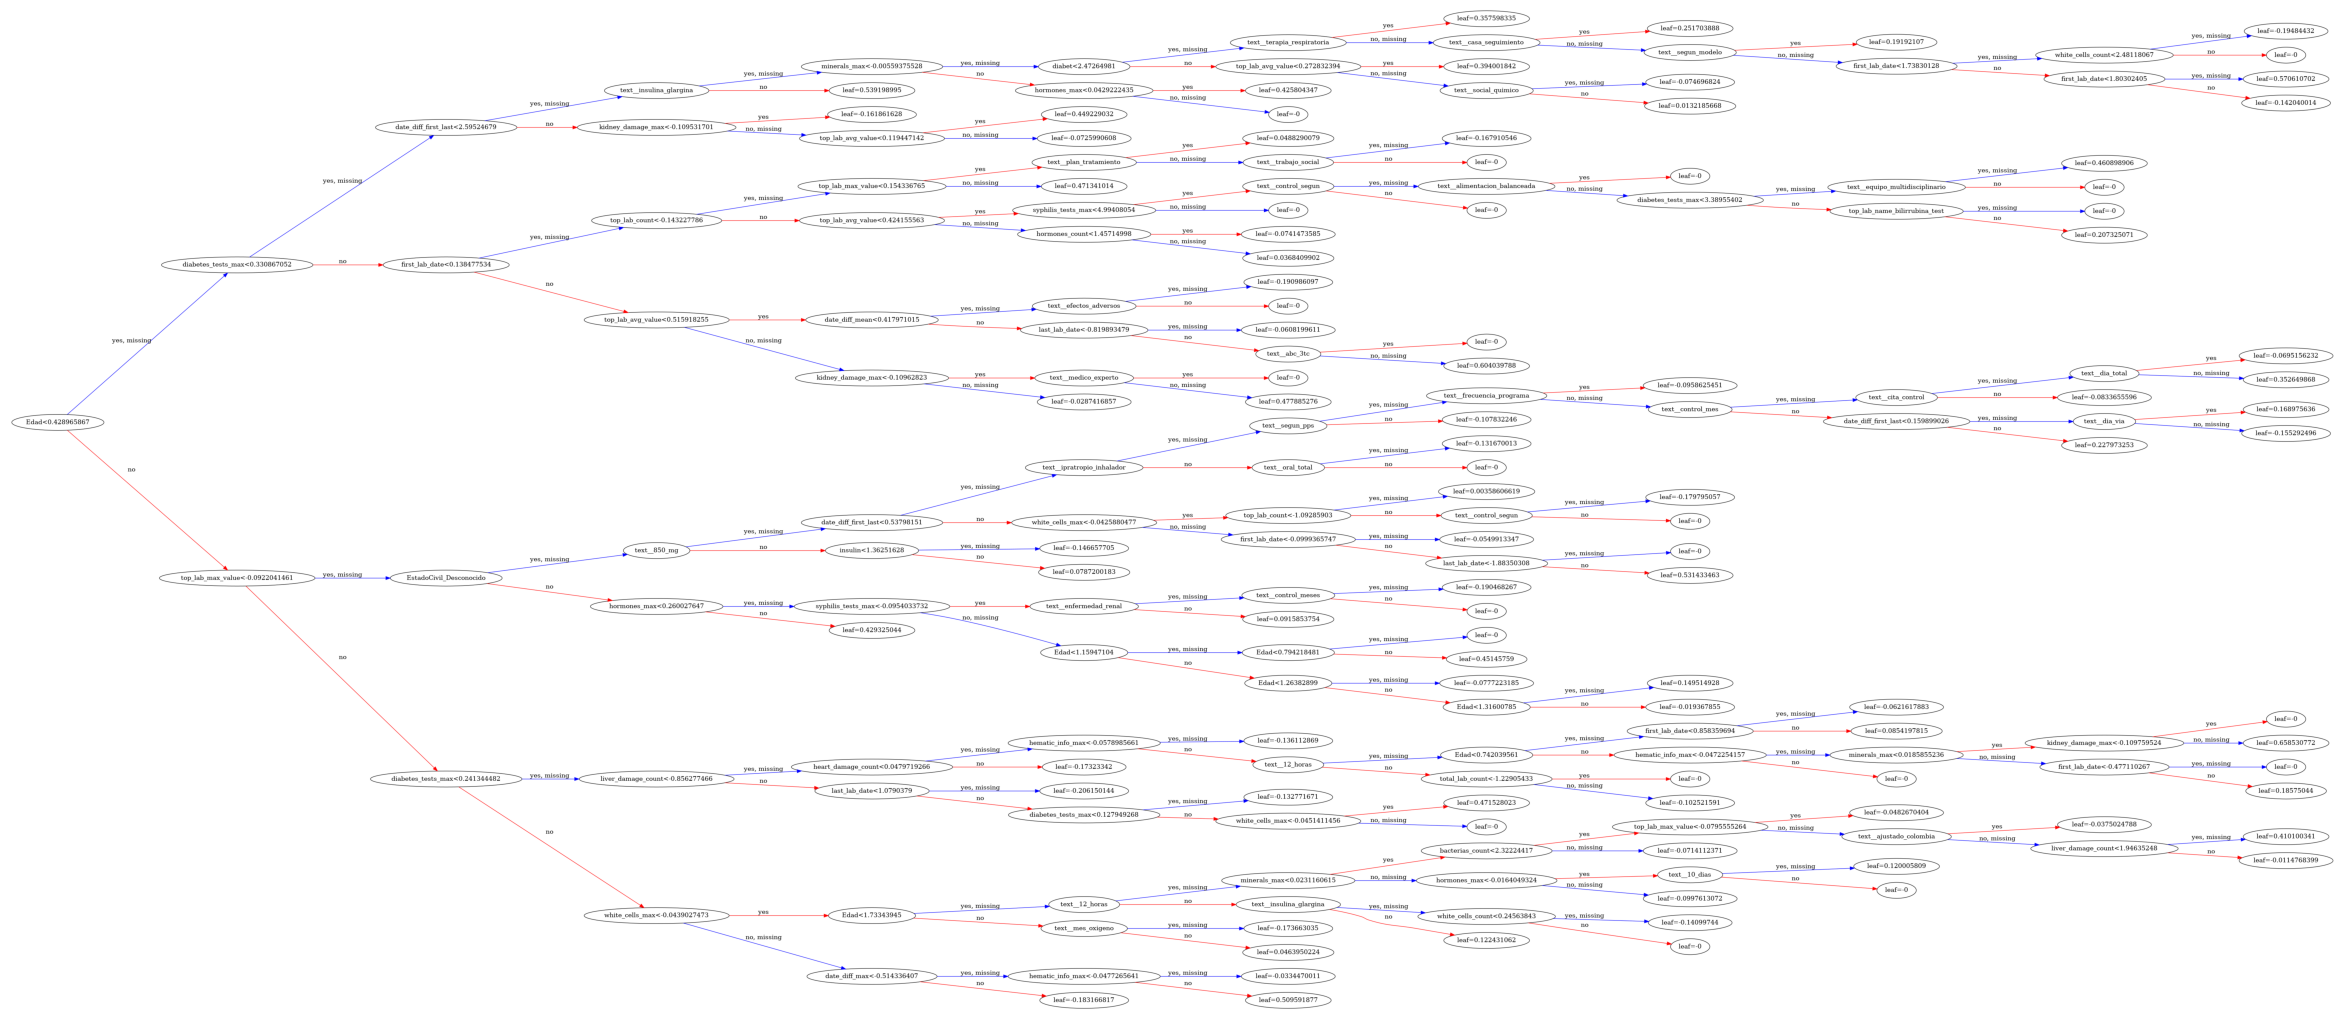

In [27]:
fig, ax = plt.subplots(figsize=(30, 15), dpi=100)
plot_tree(
    best_model.named_steps["estimator"],
    num_trees=15,
    ax=ax,
    fmap=str(fmap_save_path),
    rankdir="LR",
)
plt.show()
fig.savefig(str(figure_save_path / f"xgb_tree.png"), dpi=fig.dpi, transparent=True)

Let's get the top 20 most important features for the model

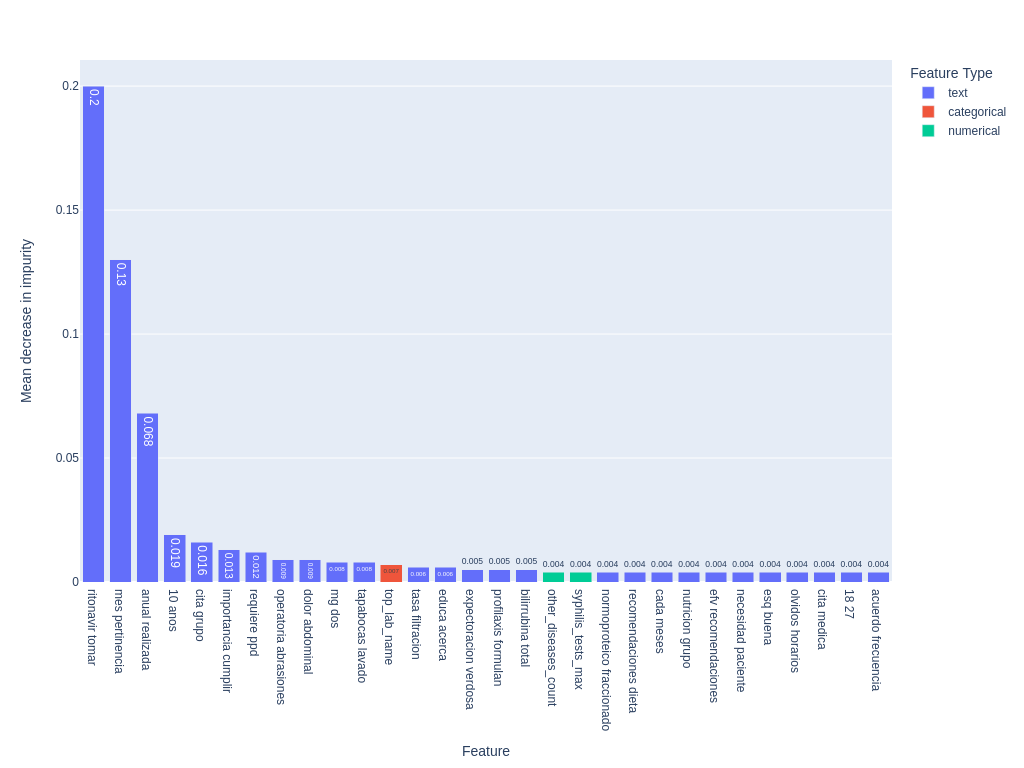

In [28]:
importances_dict = dict(
    zip(
        best_model.named_steps["feature_selector"].get_feature_names_out(
            best_model.named_steps["preprocessor"].get_feature_names_out()
        ),
        best_model.named_steps["estimator"].feature_importances_,
    )
)

for feature in categorical_features:
    feature_total_importance = 0
    for key, value in list(importances_dict.items()):
        if "categorical__" in key:
            if key[key.find("__") + 2 :].startswith(feature):
                feature_total_importance += importances_dict[key]
                del importances_dict[key]
    importances_dict[f"categorical__{feature}"] = feature_total_importance

importance_data = sorted(
    list(importances_dict.items()), key=lambda tpl: tpl[1], reverse=True
)
importance_data = importance_data[0:30]

feat_type = [val[0][: val[0].find("__")] for val in importance_data]


fig = px.bar(
    x=[val[0].split("__")[1] for val in importance_data],
    y=[round(val[1], 3) for val in importance_data],
    color=feat_type,
    text_auto=True,
    labels={"color": "Feature Type"},
)
fig.update_layout(barmode="stack", xaxis={"categoryorder": "total descending"})
fig.update_xaxes(title_text="Feature")
fig.update_yaxes(title_text="Mean decrease in impurity")
fig.show()
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)',
            )
fig.write_image(str(figure_save_path / 'feature_importance.png'), width=1024, height=768, scale=2)

Let's test the prediction of one of the samples

In [29]:
# Model test
print(
    f"Predicted :{label_encoder.inverse_transform(best_model.predict(X_test.iloc[905].to_frame().T))}, real: {label_encoder.inverse_transform([y_test[905]])}"
)

Predicted :['A539'], real: ['A539']


In [30]:
%timeit for x in range(100): best_model.predict(X_test.iloc[x].to_frame().T)

1.34 s ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Saving the best performing model and pipeline

### Saving the best model

In [32]:
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(best_model, str(save_path))
if fit_pipeline:
    dump(score, str(save_path.parent / f"best_model_score{save_path.suffix}"))


### Create and save the full prediction pipeline

In [33]:
# First retrain the model
if refit_model:
    X_resampled, y_resampled = sampler.fit_resample(X, y_labels)
    best_model.fit(X_resampled, y_resampled)

# Create the full pipeline, with the preprocessing function and label encoder/decoder
prediction_pipeline = PredictionPipeline(
    estimator=best_model,
    preprocessing_fn=clean_and_preprocess_datasets,
    label_encoder=label_encoder,
)

# Save it
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(
    prediction_pipeline,
    str(prediction_pipeline_savepath),
)


### Test the pipeline

### Preprocessed data

In [ ]:
prediction_pipeline.predict(X_test, preprocess_data=False)


### Raw data

In [ ]:
prediction_pipeline.predict(
    X={
        "df_sociodemograficos": pd.read_csv("data/sociodemografico.csv", sep=";"),
        "df_laboratorios": pd.read_csv("data/laboratorios.csv", sep=";"),
        "df_notas": pd.read_csv("data/notas.csv", sep=";"),
    }
)


In [ ]:
clean_data = clean_and_preprocess_datasets(
    {
        "df_sociodemograficos": pd.read_csv("data/sociodemografico.csv", sep=";"),
        "df_laboratorios": pd.read_csv("data/laboratorios.csv", sep=";"),
        "df_notas": pd.read_csv("data/notas.csv", sep=";"),
    }
)


In [ ]:
from utils.preprocessing_utils import preprocess_json

import json

with open("utils/sample_example.json") as in_file:
    sample_data = json.load(in_file)
sample_data

preprocess_json(sample_data)


In [ ]:
prediction_pipeline.predict(X=preprocess_json(sample_data))
